In [1]:
import iris
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/nick/python/ASoP_global/ASoP-Coherence')
sys.path.append('/home/nick/python/my-analysis/semantics')
from cmip6_dict import get_asop_dict
from semantics import ensure_bounds
import matplotlib.cm as mpl_cm
import numpy as np
import numpy.ma as ma
import pandas as pd
import skill_metrics as sm

In [2]:
def load_all_summary_metrics(asop_dict,wet_season_threshold='1d24'):
    constraints_longnames_units = [
        ('Temporal intermittency on-off metric based on 4 divisions (weighted mean of all months in wet season)','Temporal coh, 4 divs, wet seas, 3hr','1'),
        ('Probability of upper division followed by upper division (weighted mean of all months in wet season)','p(on|on), 4 divs, wet seas, 3hr','1'),
        ('Probability of upper division followed by lower division (weighted mean of all months in wet season)','p(on|off), 4 divs, wet seas, 3hr','1'),
        ('Probability of lower division followed by upper division (weighted mean of all months in wet season)','p(off|on), 4 divs, wet seas, 3hr','1'),
        ('Probability of lower division followed by lower division (weighted mean of all months in wet season)','p(off|off), 4 divs, wet seas, 3hr','1')
    ]
    out_cubelist = []
    summary_file = asop_dict['desc']+'_asop_'+asop_dict['year_range']+'_temporal_summary_wetseason'+wet_season_threshold+'.nc'
    print(asop_dict['dir']/summary_file)
    for constraint,long_name,units in constraints_longnames_units:
        cube = load_summary_metric(str(asop_dict['dir']/summary_file),constraint,long_name,units)
        out_cubelist.append(cube)
    return(out_cubelist)

In [3]:
def load_summary_metric(filename,constraint,new_long_name,new_units):
    cube = iris.load_cube(filename,constraint)
    cube.long_name = new_long_name
    cube.units = new_units
    return(cube)

In [4]:
def find_autocorr_threshold(cube,lag_length,threshold=0.5,long_name=None,units=None):
    import numpy as np
    #max_autocorr = cube.collapsed('lag',iris.analysis.MEAN).copy()
    lon = cube.coord('longitude')
    lat = cube.coord('latitude')
    nlon = len(lon.points)
    nlat = len(lat.points)
    nlag = len(cube.coord('lag').points)
#    max_autocorr = iris.cube.Cube(np.ma.empty((nlat,nlon)),dim_coords_and_dims=[(lat,0),(lon,1)])
    max_autocorr = np.zeros((nlat,nlon))
    for y in range(nlat):
        for x in range(nlon):
            below_threshold = np.where(cube.data[:,y,x] <= threshold)
            if np.sum(below_threshold) >= 1:
                max_autocorr[y,x] = np.amin(below_threshold)*lag_length+0.5
            else:
                max_autocorr[y,x] = np.nan #nlag*lag_length+0.5
    max_autocorr_cube = iris.cube.Cube(data=np.ma.masked_array(max_autocorr,np.isnan(max_autocorr)),dim_coords_and_dims=[(lat,0),(lon,1)],long_name=long_name,units=units,var_name='autocorr_threshold'+str(threshold))
    return(max_autocorr_cube) 

In [5]:
def compute_summary_stats(model_cube,obs_cube,region,region_type,region_name,diag_name,model_dict,mask=None):
    import pandas as pd
    # Average space-time summary metrics over a given region.
    # Mask for land-only if requested.
    import iris.analysis.stats as istats
    grid_constraint = iris.Constraint(latitude=lambda cell: region[0] <= cell <= region[1],
                                      longitude=lambda cell: region[2] <= cell <= region[3])
    model_region = model_cube.extract(grid_constraint)
    obs_region = obs_cube.extract(grid_constraint)
    if region_type == 'land' or region_type == 'ocean':
        if mask is None:
            raise Exception('Computing summary stats over '+region_type+' requires a mask, but mask is None.')
        model_cube = ensure_bounds(model_cube,['latitude','longitude'])
        obs_cube = ensure_bounds(obs_cube,['latitude','longitude'])
        mask = ensure_bounds(mask,['latitude','longitude'])
        mask_regrid = mask.regrid(model_region,iris.analysis.AreaWeighted())
        mask_region = mask_regrid.extract(grid_constraint)
        if region_name == 'glob':
            iris.save(mask_regrid,'lsm_'+model_dict['grid_str']+'.nc')
        print(mask_region)
        print(mask_region.data)
        if region_type == 'land':
            model_region = model_region.copy(data=np.ma.array(model_region.data,mask=np.where(mask_region.data >= 0.5,False,True)))
            obs_region = obs_region.copy(data=np.ma.array(obs_region.data,mask=np.where(mask_region.data >= 0.5,False,True)))
        if region_type == 'ocean':
            model_region = model_region.copy(data=np.ma.array(model_region.data,mask=np.where(mask_region.data < 0.5,False,True)))
            obs_region = obs_region.copy(data=np.ma.array(obs_region.data,mask=np.where(mask_region.data < 0.5,False,True)))
    weights = iris.analysis.cartography.area_weights(model_region)
    model_avg = model_region.collapsed(['longitude','latitude'],iris.analysis.MEAN,weights=weights)
    obs_avg = obs_region.collapsed(['longitude','latitude'],iris.analysis.MEAN,weights=weights)
    
    diff = model_region-obs_region
    bias = diff.collapsed(('longitude','latitude'),iris.analysis.MEAN,weights=weights)
    rmse = diff.collapsed(('longitude','latitude'),iris.analysis.RMS,weights=weights)
    std = model_region.collapsed(('longitude','latitude'),iris.analysis.STD_DEV)
    pcorr = istats.pearsonr(model_region,obs_region,weights=weights,common_mask=True) #,corr_coords=('latitude','longitude'))
    npcorr = np.corrcoef(model_region.data.flatten(),obs_region.data.flatten())[0,1]
    print(npcorr)
    #ts = sm.taylor_statistics(model_region.data.flatten(),obs_region.data.flatten(),'data')
    ts = [std.data,rmse.data,pcorr.data,bias.data]
    print(ts)
    return(ts)

In [6]:
threshold = 0.2
time_type='3hr'
if time_type == 'day':
    models=['GPM_IMERG','BCC','AWI','CanESM5','ACCESS','CESM2','CMCC','CNRM','FGOALS','GFDL','HadGEM3','INM','IPSL','KACE','MIROC','MPI','MRI','NESM','NorESM','SAM0-UNICON','TaiESM','UKESM1']
    units='Days'
    lag_length=1
elif time_type == '3hr':
    models=['GPM_IMERG','AWI','BCC','ACCESS-CM','CMCC','CNRM-LR','FGOALS','KACE','MRI','SAM']
    units='Hours'
    lag_length=3
grid_type='2x2'

In [7]:
gpm_dict = get_asop_dict('GPM_IMERG',time_type,grid_type)
gpm_temporal_summary,gpm_ponon,gpm_ponoff,gpm_poffon,gpm_poffoff = load_all_summary_metrics(gpm_dict)
gpm_autocorr_filename = str(gpm_dict['dir'])+'/'+gpm_dict['desc']+'_asop_'+gpm_dict['year_range']+'_temporal_autocorr_wetseason1d24.nc'
gpm_autocorr = load_summary_metric(gpm_autocorr_filename,'autocorr_wetseason_precip_mean',None,'Hours')

GPM_IMERG
/media/nick/lacie_tb3/datasets/GPM_IMERG/3hr/3B-HHR.MS.MRG.3IMERG.V06B.3hr_2x2_asop_2001-2019_temporal_summary_wetseason1d24.nc


In [8]:
regions = [
    ([-60,60,0,360],'glob'),
    ([-20,20,0,360],'trop'),
    ([-60,-20,0,360],'sh'),
    ([20,60,0,360],'nh'),
]
nregions = len(regions)
mask_file='/media/nick/lacie_tb3/datasets/land_sea_mask/landfrac_n216e_hadgem3-10.3.nc'
mask = iris.load_cube(mask_file,'land_area_fraction')
metrics = pd.DataFrame()

In [9]:
nmodels = len(models)
#model_names=['OBS']

        valid_max: 1.0
          valid_min: 0.0
     Cell methods:
          mean: surface
[[1.0 1.0 1.0 ... 1.0 1.0 1.0]
 [1.0 1.0 1.0 ... 1.0 1.0 1.0]
 [1.0 1.0 1.0 ... 1.0 1.0 1.0]
 ...
 [0.0 0.0 0.0008534461376257241 ... 0.8754357695579529 0.6526678204536438
  0.039529263973236084]
 [0.0 0.0 0.19176048040390015 ... 0.17540273070335388 0.11728323251008987
  0.0]
 [1.7634956828160853e-09 0.0 0.41810715198516846 ...
  0.0002941555867437273 0.0 0.06416407972574234]]
0.6463895915266725
[array(0.03416586), array(0.05860796), array(0.08188876), array(0.03181917)]
-->-->--> KACE
KACE
/media/nick/lacie_tb3/cmip6/KACE-1-0-G/KACE-1-0-G_historical_r1i1p1f1_gr_3hr_2x2_asop_1980-2014_temporal_summary_wetseason1d24.nc
/media/nick/lacie_tb3/datasets/GPM_IMERG/3hr/3B-HHR.MS.MRG.3IMERG.V06B.3hr_2x2_asop_2001-2019_temporal_summary_wetseason1d24.nc
land_area_fraction / (unknown)      (latitude: 22; longitude: 180)
     Dimension coordinates:
          latitude                           x              

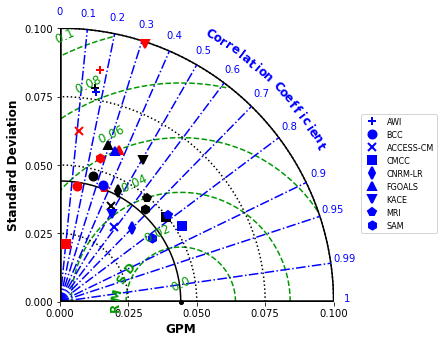

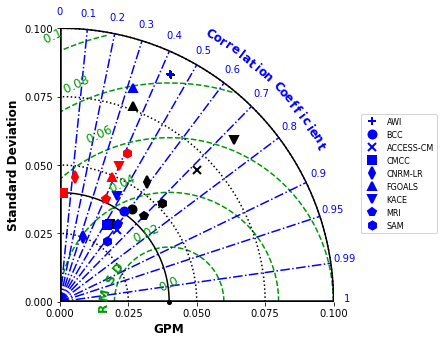

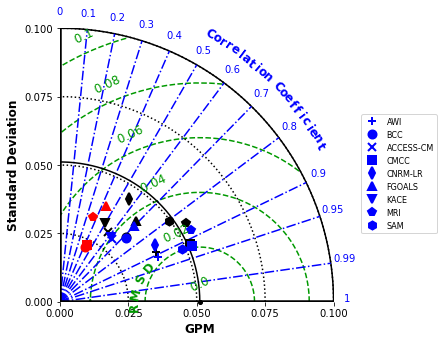

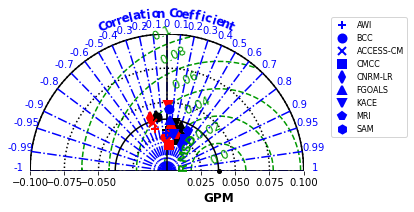

In [11]:
for region,region_name in regions:
    print('--> '+region_name)
    plt.figure(figsize=(8, 6))
    region_types=[
        ('both','off','k'),
        ('land','on','r'),
        ('ocean','on','b')
    ]
    for region_type,overlay,color in region_types:
        print('-->--> '+region_type)
        sdev = np.empty(nmodels) 
        rmsd = np.empty(nmodels)
        corr = np.empty(nmodels)
        bias = np.empty(nmodels)
        for m,model in enumerate(models):
            print('-->-->--> '+model)
            model_dict = get_asop_dict(model,time=time_type,grid=grid_type)
            model_temporal_summary,model_ponon,model_ponoff,model_poffon,model_poffoff = load_all_summary_metrics(model_dict)
            gpm_temporal_summary,gpm_ponon,gpm_ponoff,gpm_poffon,gpm_poffoff = load_all_summary_metrics(gpm_dict)
            ts = compute_summary_stats(model_temporal_summary,gpm_temporal_summary,region,region_type,region_name,'temporal_summary',model_dict,mask=mask)
            sdev[m] = np.array(ts[0])
            rmsd[m] = np.array(ts[1])
            corr[m] = np.array(ts[2])
            bias[m] = np.array(ts[3])        
        sm.taylor_diagram(sdev,rmsd,corr,markerLabel=models,markerLegend='on',markerLabelColor='k',markerColor=color, styleOBS = '-', colOBS = color, markerobs = 'o',markerSize = 8,tickRMSangle = 115, showlabelsRMS = 'on',titleRMS = 'on', titleOBS = 'GPM', checkstats = 'on',overlay=overlay,axismax=0.1,tickrms=[0,0.02,0.04,0.06,0.08,0.1]) 
        #,cmapzdata=bias,titleColorBar='Bias (hours)',markerDisplayed='colorBar')
    plt.savefig('plots/asop_coherence_global_temporal_taylor_'+time_type+'_temporalsummary_'+region_name+'.png',dpi=200)

In [ ]:
for region,region_name in regions:
    print('--> '+region_name)
    plt.figure(figsize=(8, 6))
    region_types=[
        ('both','off','k'),
        ('land','on','r'),
        ('ocean','on','b')
    ]
    for region_type,overlay,color in region_types:
        print('-->--> '+region_type)
        sdev = np.empty(nmodels) 
        rmsd = np.empty(nmodels)
        corr = np.empty(nmodels)
        bias = np.empty(nmodels)
        for m,model in enumerate(models):
            print('-->-->--> '+model)
            model_dict = get_asop_dict(model,time=time_type,grid=grid_type)
            model_autocorr_filename = str(model_dict['dir'])+'/'+model_dict['desc']+'_asop_'+model_dict['year_range']+'_temporal_autocorr_wetseason1d24.nc'
            model_autocorr = load_summary_metric(model_autocorr_filename,'autocorr_wetseason_precip_mean',None,units)
            model_autocorr_threshold = find_autocorr_threshold(model_autocorr,lag_length,threshold=threshold,long_name='Temporal corr >'+str(threshold)+', wet seas '+model_dict['name'],units='Hours')
            print(model_autocorr_threshold.collapsed(['longitude','latitude'],iris.analysis.MEAN).data)
            gpm_autocorr_filename = str(gpm_dict['dir'])+'/'+gpm_dict['desc']+'_asop_'+gpm_dict['year_range']+'_temporal_autocorr_wetseason1d24.nc'
            gpm_autocorr = load_summary_metric(gpm_autocorr_filename,'autocorr_wetseason_precip_mean',None,units)
            gpm_autocorr_threshold = find_autocorr_threshold(gpm_autocorr,lag_length,threshold=threshold,long_name='Temporal corr >'+str(threshold)+', wet seas',units=units)
            ts = compute_summary_stats(model_autocorr_threshold,gpm_autocorr_threshold,region,region_type,region_name,'autocorr_threshold'+str(threshold),model_dict,mask=mask)
            sdev[m] = np.array(ts[0])
            rmsd[m] = np.array(ts[1])
            corr[m] = np.array(ts[2])
            bias[m] = np.array(ts[3])        
        sm.taylor_diagram(sdev,rmsd,corr,markerLabel=models,markerLegend='on',markerLabelColor='k',markerColor=color, styleOBS = '-', colOBS = color, markerobs = 'o',markerSize = 8,tickRMSangle = 115, showlabelsRMS = 'on',titleRMS = 'on', titleOBS = 'GPM', checkstats = 'on',overlay=overlay,axismax=15,tickrms=[0,3,6,9,12,15]) 
        #,cmapzdata=bias,titleColorBar='Bias (hours)',markerDisplayed='colorBar')
    plt.savefig('plots/asop_coherence_global_temporal_taylor_'+time_type+'_autocorr'+str(threshold)+'_'+region_name+'.png',dpi=200)